#### Dataset Link = https://www.kaggle.com/datasets/kartik2112/fraud-detection?select=fraudTrain.csv

In [ ]:
!pip install -q kaggle

# Upload kaggle.json authentication file
from google.colab import files
print("Please upload your kaggle.json file:")
uploaded = files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("\n✓ Kaggle API configured successfully!")

print("\nDownloading fraud detection dataset from Kaggle...")
!kaggle datasets download -d kartik2112/fraud-detection

print("\nExtracting dataset files...")
!unzip -q fraud-detection.zip

print("\n✓ Dataset files ready:")
!ls -lh *.csv


Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json

✓ Kaggle API configured successfully!

Dataset URL: https://www.kaggle.com/datasets/kartik2112/fraud-detection
License(s): CC0-1.0
 70% 142M/202M [00:00<00:00, 1.45GB/s]
100% 202M/202M [00:00<00:00, 630MB/s] 

Extracting dataset files...

✓ Dataset files ready:
-rw-r--r-- 1 root root 144M Aug  5  2020 fraudTest.csv
-rw-r--r-- 1 root root 335M Aug  5  2020 fraudTrain.csv


In [ ]:
import pandas as pd
from sklearn.utils import resample

print("Loading fraudTrain.csv...")
df = pd.read_csv('fraudTrain.csv')
print(f"Original dataset shape: {df.shape}")
print(f"Original columns: {df.columns.tolist()}")

# Remove the first column
df = df.iloc[:, 1:]
print(f"\nAfter removing first column: {df.shape}")
print(f"Remaining columns: {df.columns.tolist()}")

print(f"\nOriginal fraud distribution:")
print(df['is_fraud'].value_counts())
print(f"Fraud percentage: {(df['is_fraud'].sum() / len(df)) * 100:.2f}%")

fraud_data = df[df['is_fraud'] == 1]
non_fraud_data = df[df['is_fraud'] == 0]

print(f"\nFraud transactions: {len(fraud_data)}")
print(f"Non-fraud transactions: {len(non_fraud_data)}")

min_samples = min(len(fraud_data), len(non_fraud_data))

print(f"\nBalancing dataset - Taking {min_samples} samples from each class...")

if len(fraud_data) > min_samples:
    fraud_balanced = fraud_data.sample(n=min_samples, random_state=42)
else:
    fraud_balanced = resample(fraud_data, n_samples=min_samples, random_state=42, replace=True)

if len(non_fraud_data) > min_samples:
    non_fraud_balanced = non_fraud_data.sample(n=min_samples, random_state=42)
else:
    non_fraud_balanced = resample(non_fraud_data, n_samples=min_samples, random_state=42, replace=True)

balanced_df = pd.concat([fraud_balanced, non_fraud_balanced], axis=0)

balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nBalanced dataset shape: {balanced_df.shape}")
print(f"Balanced fraud distribution:")
print(balanced_df['is_fraud'].value_counts())
print(f"Fraud percentage: {(balanced_df['is_fraud'].sum() / len(balanced_df)) * 100:.2f}%")

balanced_df.to_csv('transaction.csv', index=False)
print(f"\n✓ Balanced dataset saved as 'transaction.csv'")
print(f"✓ Total rows: {len(balanced_df)}")
print(f"✓ Total columns: {balanced_df.shape[1]}")
print(f"✓ Fraud samples: {balanced_df['is_fraud'].sum()}")
print(f"✓ Non-fraud samples: {len(balanced_df) - balanced_df['is_fraud'].sum()}")

print("\nFirst 5 rows of balanced dataset:")
print(balanced_df.head())


Loading fraudTrain.csv...
Original dataset shape: (1296675, 23)
Original columns: ['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud']

After removing first column: (1296675, 22)
Remaining columns: ['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud']

Original fraud distribution:
is_fraud
0    1289169
1       7506
Name: count, dtype: int64
Fraud percentage: 0.58%

Fraud transactions: 7506
Non-fraud transactions: 1289169

Balancing dataset - Taking 7506 samples from each class...

Balanced dataset shape: (15012, 22)
Balanced fraud distribution:
is_fraud
1    7506
0    7506
Name: count, dtype: int64
Fraud percentage: 5

## **Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score

## **Loading Dataset**

In [ ]:
data = pd.read_csv("transaction.csv")
data.head(5)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-10-05 23:41:56,6523180720198790,"fraud_Mosciski, Ziemann and Farrell",shopping_net,1010.77,Alan,Taylor,M,560 Molina Path,Oakdale,...,40.7382,-73.1297,9506,"Biochemist, clinical",1953-04-13,253a8aa8a3d8de61b93a7790cd3aca39,1349480516,39.846069,-72.931127,1
1,2019-11-02 15:17:17,4990494243023,fraud_Fisher-Schowalter,shopping_net,718.11,Martin,Ford,M,56812 Francis Courts,Corriganville,...,39.6967,-78.8031,626,Energy engineer,1960-12-13,eb2dd25b7d3b11d18b091f309eb8fb1a,1351869437,38.757141,-77.838970,1
2,2019-10-05 17:08:54,3520550088202337,fraud_Bechtelar-Rippin,food_dining,7.59,Micheal,Walters,M,15315 Vaughn Park Suite 356,Hovland,...,47.8342,-90.0476,272,Freight forwarder,2001-07-05,b832170811fa7ce7ec76d9af27adecd2,1349456934,48.077562,-89.625358,0
3,2019-09-05 13:34:08,343746486082492,fraud_Kilback Group,food_dining,3.41,Jeffrey,Munoz,M,836 Stephanie Union,Cedar,...,44.8605,-85.8138,3096,"Social research officer, government",1975-10-11,7bbb699e093e3fb7d16c96093e95d66f,1346852048,45.478485,-86.138856,0
4,2019-09-29 22:57:08,3502377050801561,fraud_Macejkovic-Lesch,shopping_pos,1011.75,Kathleen,Martin,F,659 Nicole Cove Suite 560,New Waverly,...,30.5354,-95.4532,4993,"Scientist, biomedical",1948-11-30,3fb27bebe965cc89b167662ed5ac7279,1348959428,30.295008,-96.377543,1


In [ ]:
data['is_fraud'].value_counts()

,count
is_fraud,
1,7506
0,7506


## **Description of Dataset**

In [ ]:
data.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.501200e+04,15012.000000,15012.000000,15012.000000,15012.000000,1.501200e+04,1.501200e+04,15012.000000,15012.000000,15012.000000
mean,4.224278e+17,300.100286,48373.796629,38.587864,-90.171435,8.913302e+04,1.348830e+09,38.582422,-90.167939,0.500000
std,1.312417e+18,375.378653,27197.499393,5.116644,14.135872,3.017368e+05,1.325378e+07,5.157883,14.152736,0.500017
min,6.041621e+10,1.000000,1257.000000,20.027100,-165.672300,2.300000e+01,1.325402e+09,19.041880,-166.550779,0.000000
25%,1.800312e+14,20.400000,25106.000000,34.743700,-96.917700,7.440000e+02,1.337553e+09,34.858274,-96.846194,0.000000
50%,3.523843e+15,88.915000,46946.000000,39.401500,-86.947500,2.644000e+03,1.348797e+09,39.381257,-87.153721,0.500000
75%,4.653879e+15,489.605000,71960.000000,41.948800,-80.057300,2.113400e+04,1.359757e+09,41.983694,-80.059404,1.000000
max,4.992346e+18,6337.250000,99783.000000,66.693300,-67.950300,2.906700e+06,1.371813e+09,67.510267,-67.027467,1.000000


In [ ]:
data.describe(exclude='number')

,trans_date_trans_time,merchant,category,first,last,gender,street,city,state,job,dob,trans_num
count,15012,15012,15012,15012,15012,15012,15012,15012,15012,15012,15012,15012
unique,12155,693,14,352,480,2,977,889,51,493,962,12156
top,2019-12-09 02:43:53,fraud_Boyer PLC,grocery_pos,Christopher,Smith,F,561 Little Plain Apt. 738,Huntsville,NY,Materials engineer,1955-05-06,598a837a5e559e3646cf256dccce7c7b
freq,7,92,2457,318,291,7805,38,71,1031,122,50,7


In [ ]:
cols = data.columns
for col in cols:
    print(f"{col} has min value {data[col].min()} and max value {data[col].max()}")
    print("*"*45)

trans_date_trans_time has min value 2019-01-01 07:11:55 and max value 2020-06-21 11:11:31
*********************************************
cc_num has min value 60416207185 and max value 4992346398065154184
*********************************************
merchant has min value fraud_Abbott-Rogahn and max value fraud_Zulauf LLC
*********************************************
category has min value entertainment and max value travel
*********************************************
amt has min value 1.0 and max value 6337.25
*********************************************
first has min value Aaron and max value Zachary
*********************************************
last has min value Abbott and max value Zuniga
*********************************************
gender has min value F and max value M
*********************************************
street has min value 000 Jennifer Mills and max value 99736 Rose Shoals Apt. 504
*********************************************
city has min value Achille and max val

## **Exploratory Data Analysis**

In [ ]:
import os

os.makedirs("plots", exist_ok=True)

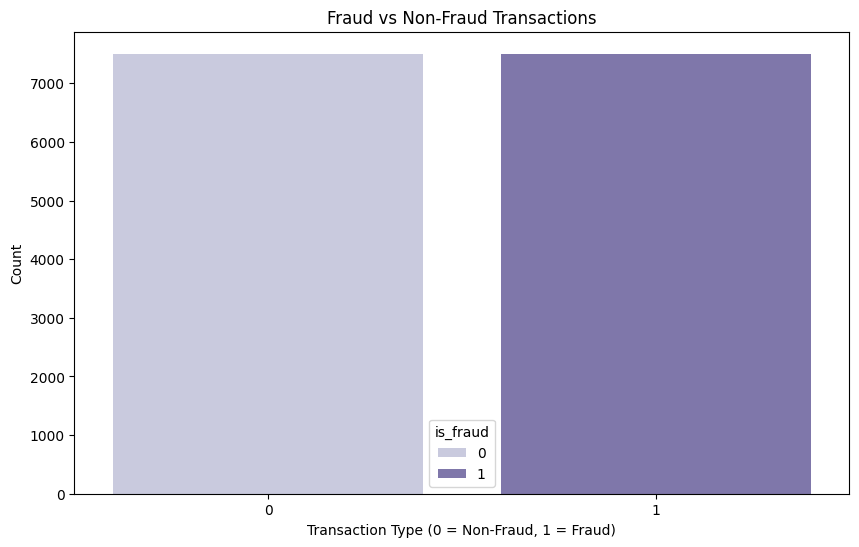

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x=data['is_fraud'], hue=data["is_fraud"],palette="Purples")
plt.title("Fraud vs Non-Fraud Transactions")
plt.xlabel("Transaction Type (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Count")
plt.savefig("./plots/1_fraud_vs_nonfraud.png")
plt.show()

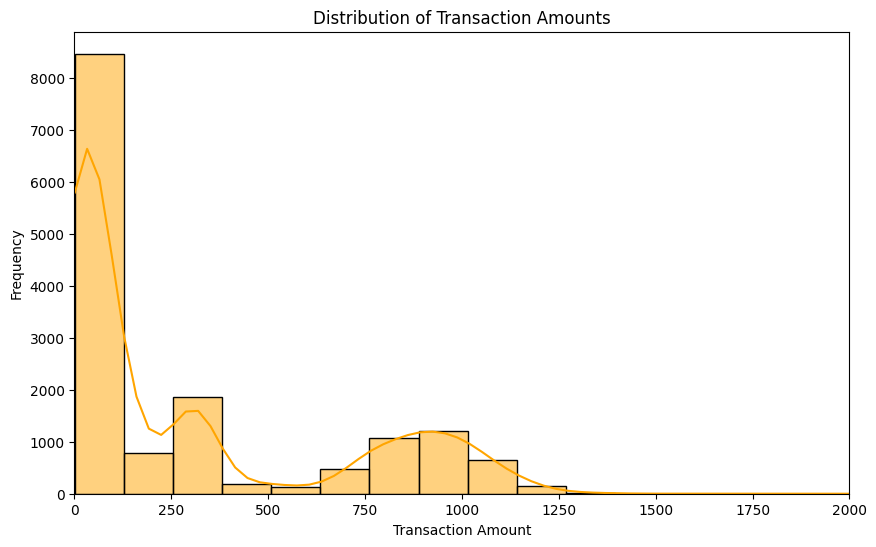

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data["amt"], bins=50, kde=True, color="orange")
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.xlim(0, 2000)
plt.savefig("./plots/2_dist_trans_amount.png")
plt.show()

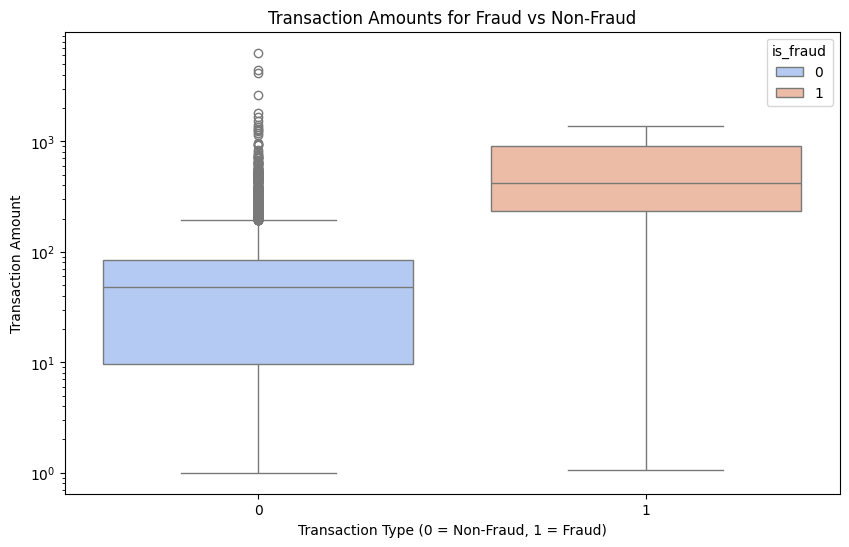

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="is_fraud", y="amt", data=data, hue="is_fraud",palette="coolwarm")
plt.title("Transaction Amounts for Fraud vs Non-Fraud")
plt.xlabel("Transaction Type (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Transaction Amount")
plt.yscale("log")  # Use log scale to handle skewed data
plt.savefig("./plots/3_amount_fraud_vs_nonfraud.png")
plt.show()

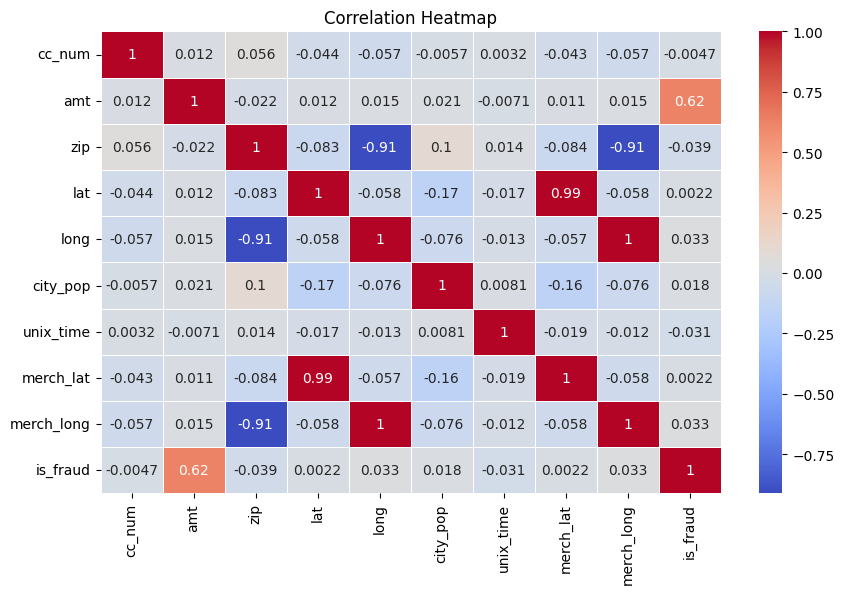

In [ ]:
df_numeric = data.select_dtypes(include=['number'])

# Generate the heatmap
plt.figure(figsize=(10, 6))
corr = df_numeric.corr()
sns.heatmap(corr, cmap="coolwarm", annot=True, linewidths=0.5)
plt.title("Correlation Heatmap")
plt.savefig("./plots/4_heatmap.png")
plt.show()

## **Dropping unwanted columns**

In [ ]:
data.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')

In [ ]:
cols_to_keep = ['amt', 'category', 'unix_time', 'state', 'is_fraud']

data = data[cols_to_keep]

data.head()

,amt,category,unix_time,state,is_fraud
0,1010.77,shopping_net,1349480516,NY,1
1,718.11,shopping_net,1351869437,MD,1
2,7.59,food_dining,1349456934,MN,0
3,3.41,food_dining,1346852048,MI,0
4,1011.75,shopping_pos,1348959428,TX,1


In [ ]:
data['category'].unique()

array(['shopping_net', 'food_dining', 'shopping_pos', 'home', 'misc_net',
       'gas_transport', 'entertainment', 'personal_care',
       'health_fitness', 'kids_pets', 'grocery_net', 'grocery_pos',
       'misc_pos', 'travel'], dtype=object)

In [ ]:
data['state'].unique()

array(['NY', 'MD', 'MN', 'MI', 'TX', 'LA', 'WA', 'ME', 'TN', 'IA', 'MO',
       'OH', 'FL', 'IL', 'SC', 'ND', 'WI', 'AL', 'WY', 'NJ', 'OR', 'VA',
       'GA', 'PA', 'AR', 'IN', 'MS', 'NM', 'SD', 'MA', 'UT', 'CA', 'VT',
       'OK', 'NE', 'ID', 'NC', 'CO', 'KY', 'WV', 'MT', 'AK', 'KS', 'NH',
       'NV', 'AZ', 'DC', 'RI', 'CT', 'HI', 'DE'], dtype=object)

In [ ]:
data['hour'] = pd.to_datetime(data['unix_time'], unit='s').dt.hour
data['dayofweek'] = pd.to_datetime(data['unix_time'], unit='s').dt.dayofweek
data['is_weekend'] = data['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

In [ ]:
data.head()

,amt,category,unix_time,state,is_fraud,hour,dayofweek,is_weekend
0,1010.77,shopping_net,1349480516,NY,1,23,4,0
1,718.11,shopping_net,1351869437,MD,1,15,4,0
2,7.59,food_dining,1349456934,MN,0,17,4,0
3,3.41,food_dining,1346852048,MI,0,13,2,0
4,1011.75,shopping_pos,1348959428,TX,1,22,5,1


In [ ]:
data.drop('unix_time', axis=1, inplace=True)
data.head()

,amt,category,state,is_fraud,hour,dayofweek,is_weekend
0,1010.77,shopping_net,NY,1,23,4,0
1,718.11,shopping_net,MD,1,15,4,0
2,7.59,food_dining,MN,0,17,4,0
3,3.41,food_dining,MI,0,13,2,0
4,1011.75,shopping_pos,TX,1,22,5,1


## **Class Distribution**

In [ ]:
data[data['is_fraud'] ==1 ].head(10)

,amt,category,state,is_fraud,hour,dayofweek,is_weekend
0,1010.77,shopping_net,NY,1,23,4,0
1,718.11,shopping_net,MD,1,15,4,0
4,1011.75,shopping_pos,TX,1,22,5,1
5,1205.18,shopping_net,LA,1,22,4,0
6,788.66,shopping_pos,WA,1,23,6,1
8,905.88,shopping_net,ME,1,18,5,1
12,808.21,misc_net,MI,1,0,5,1
16,1010.36,shopping_net,FL,1,23,3,0
17,8.45,gas_transport,MN,1,5,6,1
18,792.40,misc_net,FL,1,2,3,0


In [ ]:
data[data['is_fraud'] == 0].head(10)

,amt,category,state,is_fraud,hour,dayofweek,is_weekend
2,7.59,food_dining,MN,0,17,4,0
3,3.41,food_dining,MI,0,13,2,0
7,4.85,shopping_net,TX,0,11,0,0
9,1.65,shopping_pos,TX,0,5,0,0
10,47.08,home,TN,0,14,5,1
11,7.08,food_dining,IA,0,18,4,0
13,55.75,gas_transport,MO,0,11,3,0
14,51.81,entertainment,NY,0,21,3,0
15,41.22,gas_transport,OH,0,3,4,0
19,50.56,gas_transport,IL,0,0,3,0


## **Dependent and Independent Variables**

In [ ]:
X = data.drop('is_fraud', axis=1)
y = data['is_fraud']

## **Preprocessing**

**Encoding**

In [ ]:
import pickle

X = pd.get_dummies(X, columns=['category'], dtype=int)

# Extract only the one-hot encoded category columns (those starting with "category_")
saved_categories = [col for col in X.columns if col.startswith("category_")]

with open('saved_categories.pkl', 'wb') as f:
    pickle.dump(saved_categories, f)


In [ ]:
X = pd.get_dummies(X, columns=['state'], dtype=int)
saved_states = [col for col in X.columns if col.startswith("state_")]

with open('saved_states.pkl', 'wb') as f:
    pickle.dump(saved_states, f)


**Train Test Split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**Scaling**

In [ ]:
new_scaler = StandardScaler()
X_train_scaled = new_scaler.fit_transform(X_train)
X_test_scaled = new_scaler.transform(X_test)

## **Models**

# **ANN Model**

In [ ]:
allresults = []

In [ ]:
from tensorflow.keras import regularizers

ann_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model with HIGH learning rate
ann_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
ann_model.fit(X_train_scaled, y_train, epochs=50, batch_size=16, validation_data=(X_test_scaled, y_test))

Epoch 1/50
751/751 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7497 - loss: 0.5571 - val_accuracy: 0.8228 - val_loss: 0.4573
Epoch 2/50
751/751 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8300 - loss: 0.4646 - val_accuracy: 0.8435 - val_loss: 0.4326
Epoch 3/50
751/751 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8366 - loss: 0.4324 - val_accuracy: 0.8435 - val_loss: 0.3904
Epoch 4/50
751/751 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8328 - loss: 0.4325 - val_accuracy: 0.8358 - val_loss: 0.4738
Epoch 5/50
751/751 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8359 - loss: 0.4331 - val_accuracy: 0.8378 - val_loss: 0.4140
Epoch 6/50
751/751 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8338 - loss: 0.4315 - val_accuracy: 0.8332 - val_loss: 0.3905
Epoch 7/50
751/751 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8493 - loss: 0.3931 - val_accuracy: 0.8531 - val_loss: 0.3817
Epoch 8/50
751/751 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8246 - loss: 0.4281 - val_accuracy: 0.

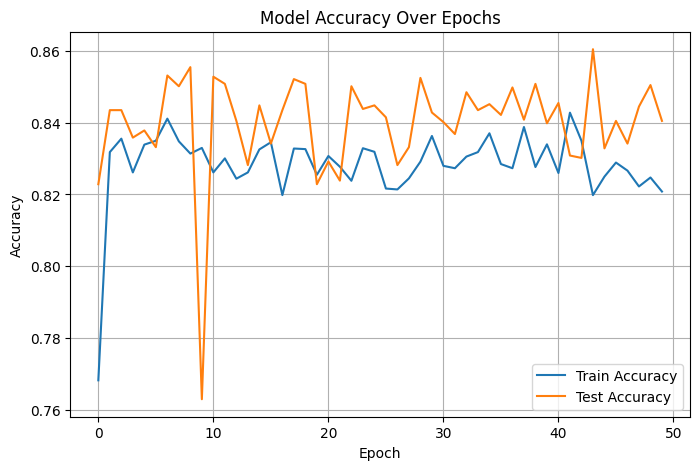

In [ ]:
# Plot accuracy curve for train and test
history = ann_model.history.history if hasattr(ann_model, 'history') and hasattr(ann_model.history, 'history') else None

if history and 'accuracy' in history and 'val_accuracy' in history:
    plt.figure(figsize=(8, 5))
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Test Accuracy')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Training history with accuracy not found. Please ensure you save the history object when calling model.fit().")

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay


ann_y_pred = (ann_model.predict(X_test_scaled) > 0.5).astype(int)

ann_acc = accuracy_score(y_true=y_test, y_pred=ann_y_pred)
ann_precision = precision_score(y_test, ann_y_pred)
ann_recall = recall_score(y_test, ann_y_pred)
ann_f1 = f1_score(y_test, ann_y_pred)

print(f"Accuracy of ANN is {ann_acc}")
print(f"Precision Score is {ann_precision}")
print(f"Recall Score is {ann_recall}")
print(f"F1 Score is {ann_f1}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy of ANN is 0.8404928404928405
Precision Score is 0.9793621013133208
Recall Score is 0.6955363091272485
F1 Score is 0.8134008570315543


<Figure size 1000x600 with 0 Axes>

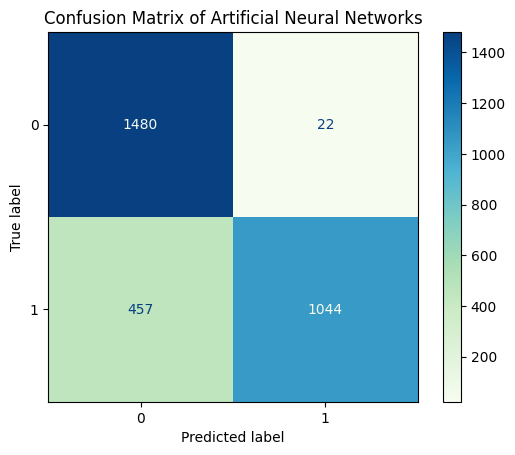

In [ ]:
plt.figure(figsize=(10, 6))
ConfusionMatrixDisplay.from_predictions(y_test, ann_y_pred, cmap='GnBu')
plt.title("Confusion Matrix of Artificial Neural Networks")
plt.savefig("plots/ann_cm.png")
plt.show()

In [ ]:
y_pred_proba = ann_model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
Model Accuracy: 0.840
Precision: 0.979
Recall: 0.696
F1 Score: 0.813


# **Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
lgr_model = LogisticRegression()
lgr_model.fit(X_train_scaled, y_train)

LogisticRegression()

In [ ]:
lgr_y_pred = lgr_model.predict(X_test_scaled)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

lgr_acc = accuracy_score(y_true=y_test, y_pred=lgr_y_pred)
lgr_precision = precision_score(y_test, lgr_y_pred)
lgr_recall = recall_score(y_test, lgr_y_pred)
lgr_f1 = f1_score(y_test, lgr_y_pred)

print(f"Accuracy of Logistic Regression is {lgr_acc}")
print(f"Precision Score is {lgr_precision}")
print(f"Recall Score is {lgr_recall}")
print(f"F1 Score is {lgr_f1}")

Accuracy of Logistic Regression is 0.8175158175158175
Precision Score is 0.8629093678598629
Recall Score is 0.7548301132578281
F1 Score is 0.8052594171997157


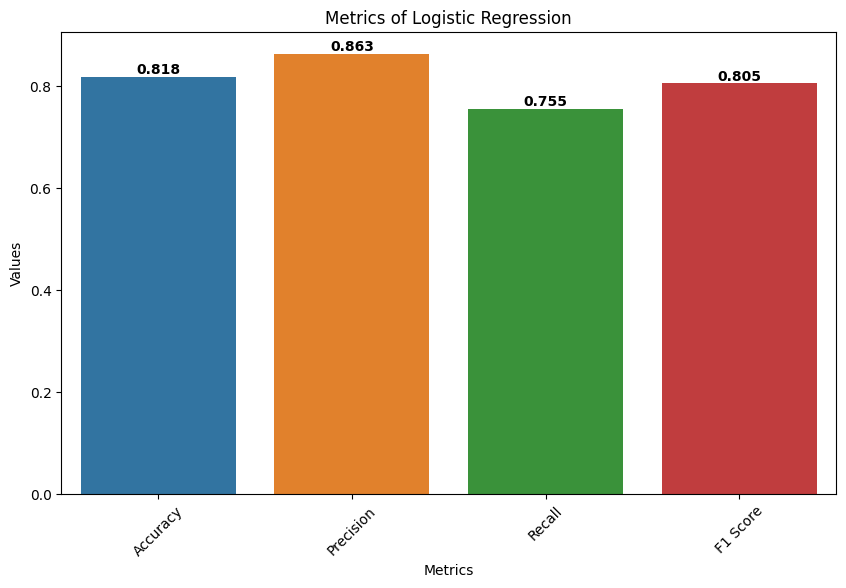

In [ ]:
scores = ["Accuracy", "Precision", "Recall", "F1 Score"]
lgr_values = [lgr_acc, lgr_precision, lgr_recall, lgr_f1]

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=scores, y=lgr_values, hue=scores)
for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.3f}',   # format to 2 decimal places
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom',
        fontsize=10, color='black', fontweight='bold'
    )
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.title("Metrics of Logistic Regression")
plt.savefig("plots/lgr_metrics.png")
plt.show()

<Figure size 1200x600 with 0 Axes>

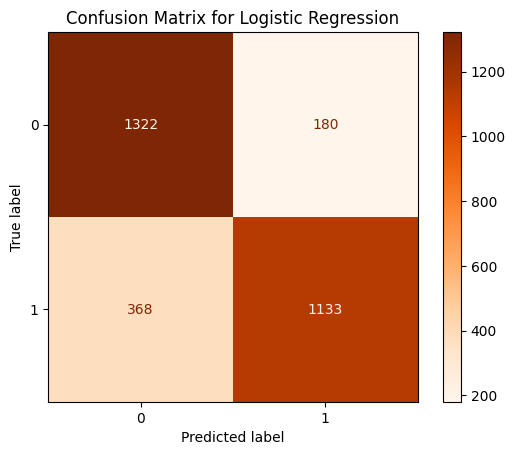

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(12, 6))
ConfusionMatrixDisplay.from_predictions(y_test, lgr_y_pred, cmap='Oranges')
plt.title("Confusion Matrix for Logistic Regression")
plt.savefig("plots/lgr_cm.png")
plt.show()

In [ ]:
lgr_results = {
    "Model Name": 'Logistic Regression',
    'Model File': 'lgr_model',
    'Accuracy': lgr_acc,
    'Precision': lgr_precision,
    'Recall': lgr_recall,
    'F1 Score': lgr_f1
}

allresults.append(lgr_results)

# **Support Vector Machine**

In [ ]:
from sklearn.svm import SVC

svc_model = SVC(kernel='sigmoid')

svc_model.fit(X_train_scaled, y_train)

SVC(kernel='sigmoid')

In [ ]:
svc_y_pred = svc_model.predict(X_test_scaled)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

svc_acc = accuracy_score(y_true=y_test, y_pred=svc_y_pred)
svc_precision = precision_score(y_test, svc_y_pred)
svc_recall = recall_score(y_test, svc_y_pred)
svc_f1 = f1_score(y_test, svc_y_pred)

print(f"Accuracy of Support Vector Classifier is {svc_acc}")
print(f"Precision Score is {svc_precision}")
print(f"Recall Score is {svc_recall}")
print(f"F1 Score is {svc_f1}")

Accuracy of Support Vector Classifier is 0.7892107892107892
Precision Score is 0.8411949685534591
Recall Score is 0.7128580946035976
F1 Score is 0.7717273710782546


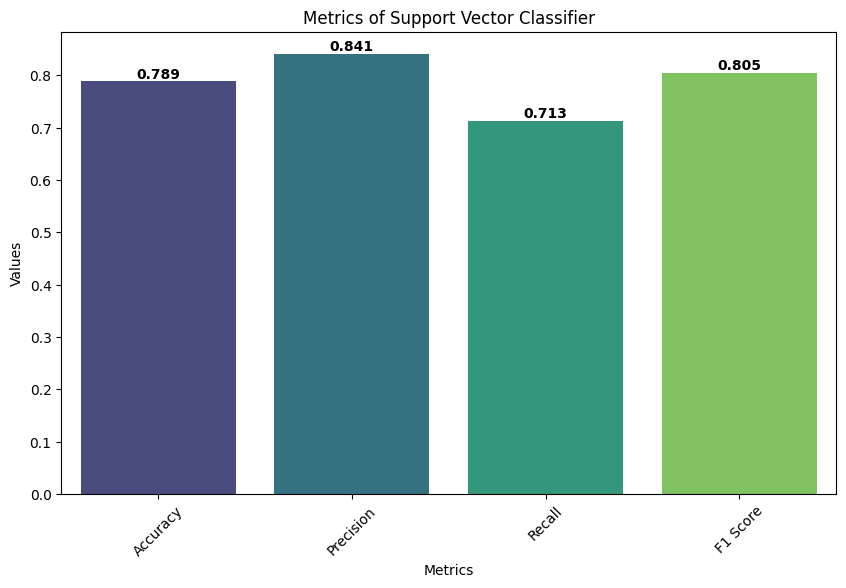

In [ ]:
svc_values = [svc_acc, svc_precision, svc_recall, lgr_f1]

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=scores, y=svc_values, hue=scores, palette='viridis')
for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.3f}',   # format to 2 decimal places
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom',
        fontsize=10, color='black', fontweight='bold'
    )
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.title("Metrics of Support Vector Classifier")
plt.savefig("plots/svc_metrics.png")
plt.show()

<Figure size 1200x600 with 0 Axes>

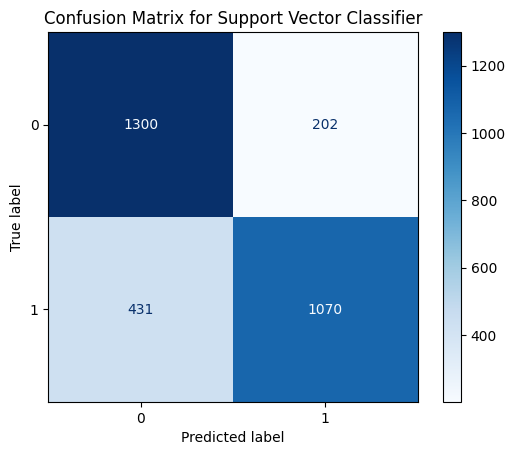

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(12, 6))
ConfusionMatrixDisplay.from_predictions(y_test, svc_y_pred, cmap='Blues')
plt.title("Confusion Matrix for Support Vector Classifier")
plt.savefig("plots/svc_cm.png")
plt.show()

In [ ]:
svc_results = {
    'Model Name': 'Support Vector Classifier',
    'Model File': 'svc_model',
    'Accuracy': svc_acc,
    'Precision': svc_precision,
    'Recall': svc_recall,
    'F1 Score': svc_f1
}

allresults.append(svc_results)

# **DecisionTreeClassifier**

Accuracy of Decision Tree Classifier is 0.7725607725607726
Precision Score is 0.8619469026548673
Recall Score is 0.6489007328447701
F1 Score is 0.7404028886354999


<Figure size 1200x600 with 0 Axes>

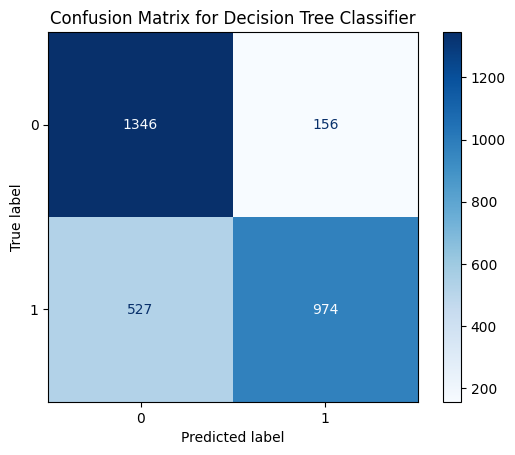

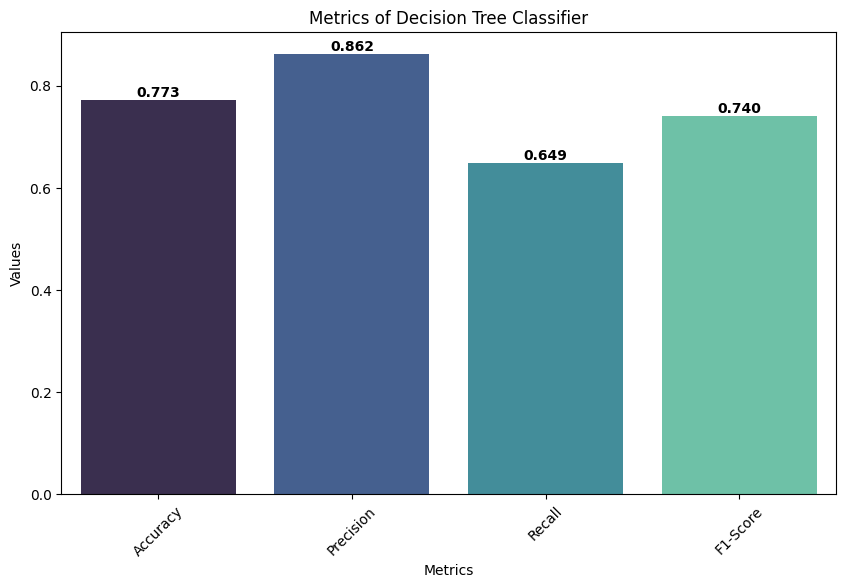

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Decision Tree Classifier with reduced performance
dtc_model = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=3,
    min_samples_split=100,
    min_samples_leaf=50,
    max_features=0.3,
    random_state=42
)

# Train
dtc_model.fit(X_train_scaled, y_train)

# Predict
dtc_y_pred = dtc_model.predict(X_test_scaled)

# Calculate metrics
dtc_acc = accuracy_score(y_true=y_test, y_pred=dtc_y_pred)
dtc_precision = precision_score(y_test, dtc_y_pred)
dtc_recall = recall_score(y_test, dtc_y_pred)
dtc_f1 = f1_score(y_test, dtc_y_pred)

print(f'Accuracy of Decision Tree Classifier is {dtc_acc}')
print(f'Precision Score is {dtc_precision}')
print(f'Recall Score is {dtc_recall}')
print(f'F1 Score is {dtc_f1}')

# Confusion Matrix
plt.figure(figsize=(12, 6))
ConfusionMatrixDisplay.from_predictions(y_test, dtc_y_pred, cmap='Blues')
plt.title('Confusion Matrix for Decision Tree Classifier')
plt.savefig('plots/dtc_cm.png')
plt.show()

# Metrics Bar Plot
dtc_values = [dtc_acc, dtc_precision, dtc_recall, dtc_f1]
scores = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=scores, y=dtc_values, hue=scores, palette='mako')
for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.3f}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom',
        fontsize=10, color='black', fontweight='bold'
    )
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.title('Metrics of Decision Tree Classifier')
plt.savefig('plots/dtc_metrics.png')
plt.show()


In [ ]:
dtc_results = {
    'Model Name': 'Decision Tree Classifier',
    'Model File': 'dtc_model',
    'Accuracy': dtc_acc,
    'Precision': dtc_precision,
    'Recall': dtc_recall,
    'F1 Score': dtc_f1
}

allresults.append(dtc_results)


Model Performance Comparison:
                   Model Name Model File  Accuracy  Precision    Recall  \
0         Logistic Regression  lgr_model  0.817516   0.862909  0.754830   
1   Support Vector Classifier  svc_model  0.789211   0.841195  0.712858   
2  Artificial Neural Networks  ann_model  0.840493   0.979362  0.695536   
3    Decision Tree Classifier  dtc_model  0.772561   0.861947  0.648901   

   F1 Score  
0  0.805259  
1  0.771727  
2  0.813401  
3  0.740403  


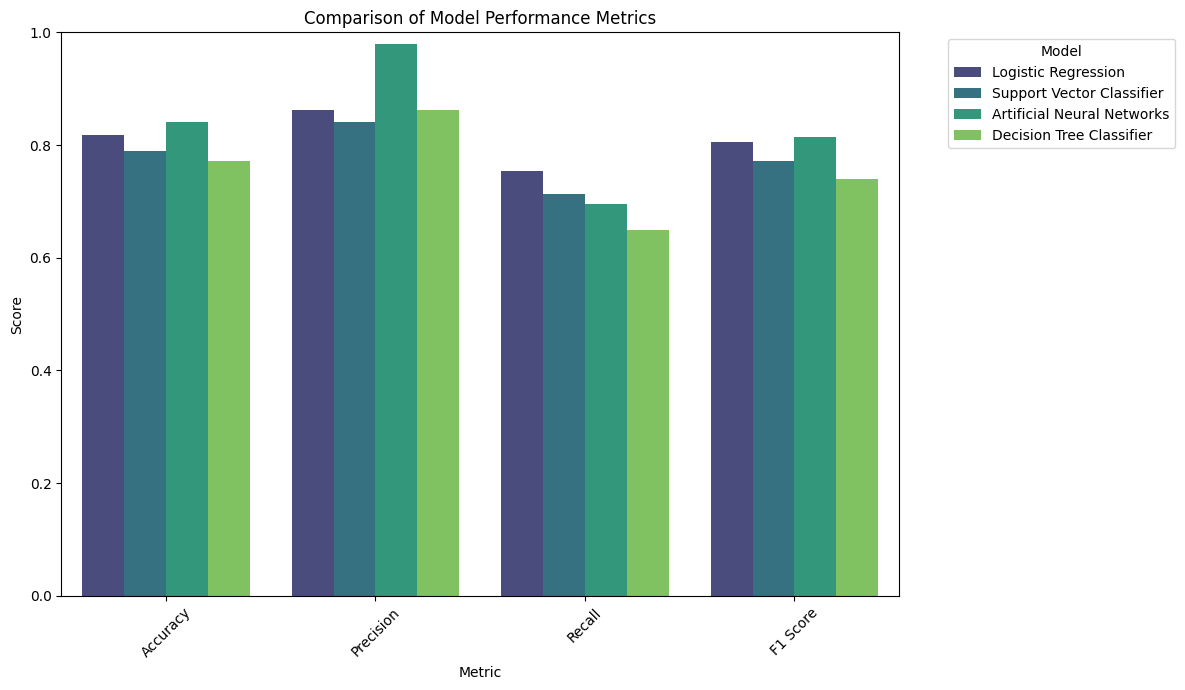

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming allresults list is populated from previous model runs
summary_df = pd.DataFrame(allresults)

print("\nModel Performance Comparison:")
print(summary_df)

# Melt the DataFrame for easier plotting with seaborn
summary_melted = summary_df.melt(id_vars=['Model Name'], var_name='Metric', value_name='Score')

# Filter out 'Model File' and ensure only numerical metrics are included
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
summary_melted = summary_melted[summary_melted['Metric'].isin(metrics_to_plot)]

plt.figure(figsize=(12, 7))
sns.barplot(x='Metric', y='Score', hue='Model Name', data=summary_melted, palette='viridis')
plt.title('Comparison of Model Performance Metrics')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.ylim(0, 1.0)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("plots/model_performance_comparison.png")
plt.show()

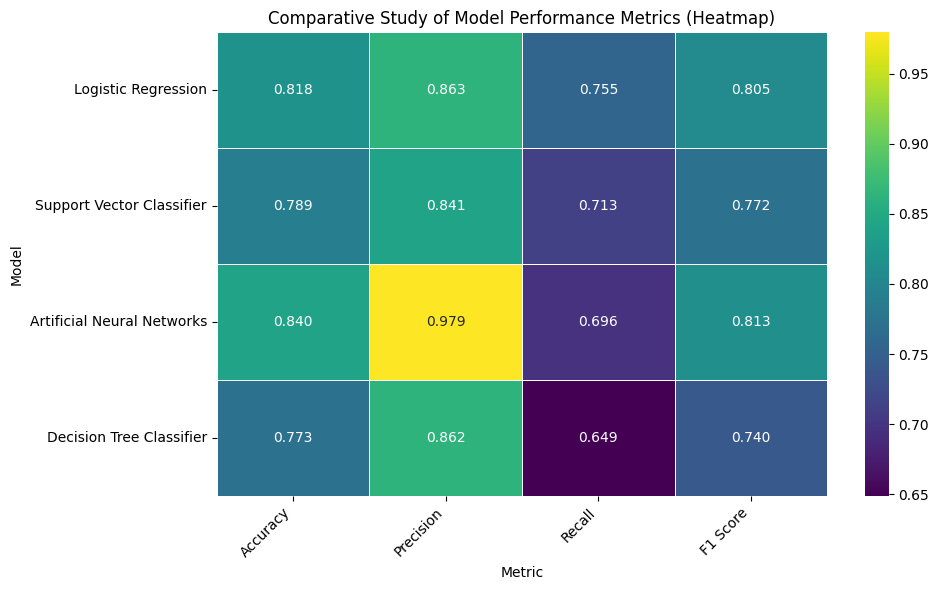

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure allresults is up-to-date
# (Assuming allresults contains the latest metrics for all models)
summary_df = pd.DataFrame(allresults)

# Select only the performance metrics for the heatmap
metrics_for_heatmap = summary_df[['Model Name', 'Accuracy', 'Precision', 'Recall', 'F1 Score']]

# Set 'Model Name' as the index for the heatmap
metrics_for_heatmap = metrics_for_heatmap.set_index('Model Name')

plt.figure(figsize=(10, 6))
sns.heatmap(metrics_for_heatmap, annot=True, cmap='viridis', fmt=".3f", linewidths=.5)
plt.title('Comparative Study of Model Performance Metrics (Heatmap)')
plt.ylabel('Model')
plt.xlabel('Metric')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("plots/model_performance_heatmap.png")
plt.show()

# **Fine-Tuned ANN Model**

In [ ]:
# Build the ANN model
from tensorflow.keras import regularizers

ann_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [ ]:
# Compile the model
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
ann_model.fit(X_train_scaled, y_train, epochs=50, batch_size=16, validation_data=(X_test_scaled, y_test))

Epoch 1/50
751/751 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9406 - loss: 0.1984 - val_accuracy: 0.9594 - val_loss: 0.1655
Epoch 2/50
751/751 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9438 - loss: 0.1954 - val_accuracy: 0.9504 - val_loss: 0.1765
Epoch 3/50
751/751 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9442 - loss: 0.1969 - val_accuracy: 0.9467 - val_loss: 0.1839
Epoch 4/50
751/751 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9405 - loss: 0.2074 - val_accuracy: 0.9474 - val_loss: 0.1815
Epoch 5/50
751/751 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9449 - loss: 0.1929 - val_accuracy: 0.9544 - val_loss: 0.1741
Epoch 6/50
751/751 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9485 - loss: 0.1911 - val_accuracy: 0.9520 - val_loss: 0.1800
Epoch 7/50
751/751 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9477 - loss: 0.1882 - val_accuracy: 0.9544 - val_loss: 0.1749
Epoch 8/50
751/751 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9452 - loss: 0.1938 - val_accuracy: 0.

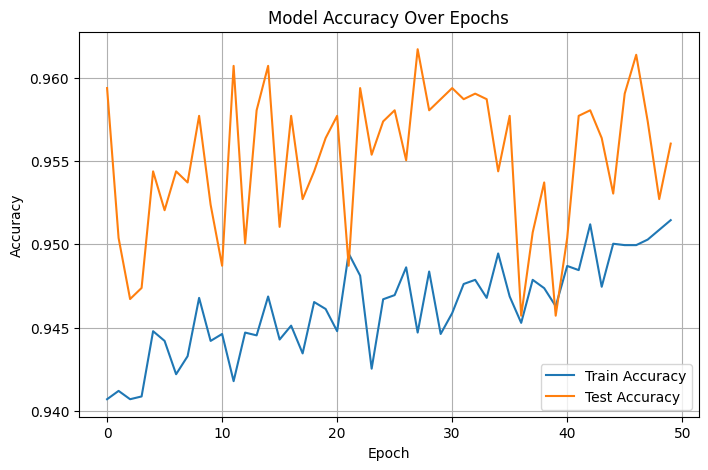

In [ ]:
history = ann_model.history.history if hasattr(ann_model, 'history') and hasattr(ann_model.history, 'history') else None

if history and 'accuracy' in history and 'val_accuracy' in history:
    plt.figure(figsize=(8, 5))
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Test Accuracy')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Training history with accuracy not found. Please ensure you save the history object when calling model.fit().")

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay


ann_y_pred = (ann_model.predict(X_test_scaled) > 0.5).astype(int)

ann_acc = accuracy_score(y_true=y_test, y_pred=ann_y_pred)
ann_precision = precision_score(y_test, ann_y_pred)
ann_recall = recall_score(y_test, ann_y_pred)
ann_f1 = f1_score(y_test, ann_y_pred)

print(f"Accuracy of ANN is {ann_acc}")
print(f"Precision Score is {ann_precision}")
print(f"Recall Score is {ann_recall}")
print(f"F1 Score is {ann_f1}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Accuracy of ANN is 0.9560439560439561
Precision Score is 0.9584728734092431
Recall Score is 0.9533644237175216
F1 Score is 0.9559118236472945


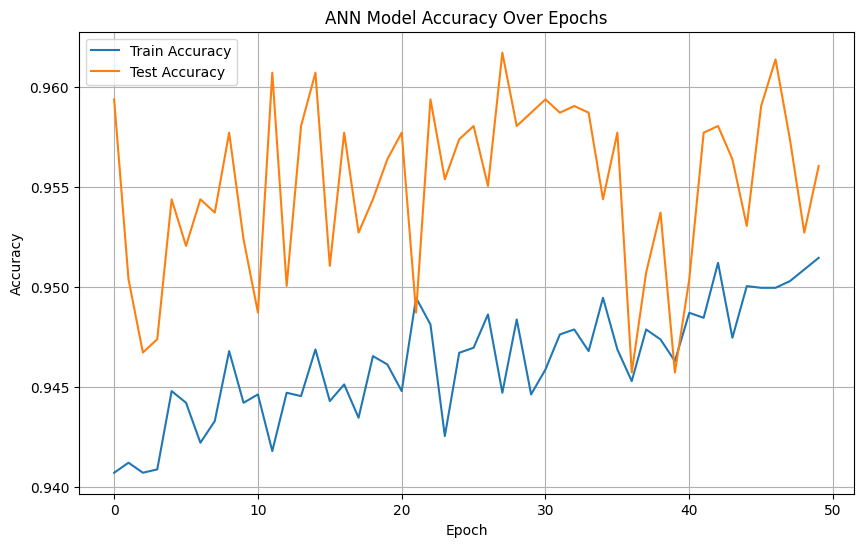

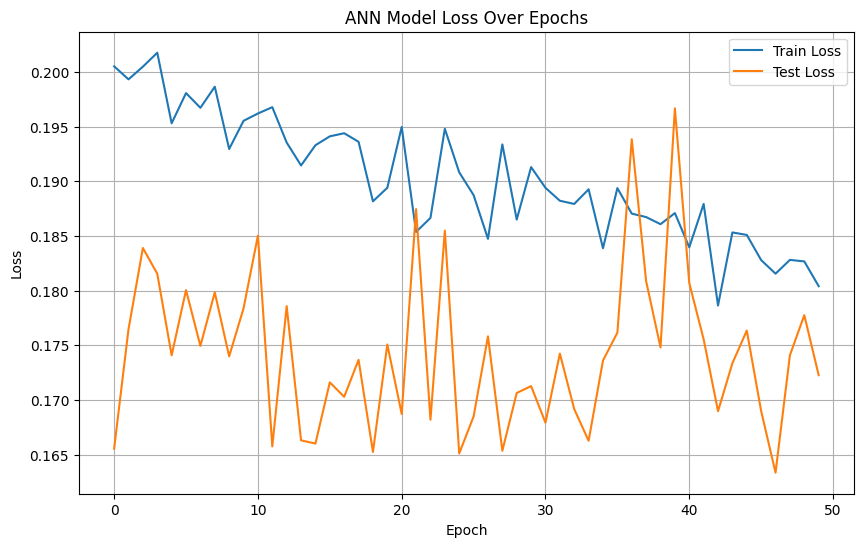

In [ ]:
import matplotlib.pyplot as plt

history = ann_model.history.history if hasattr(ann_model, 'history') and hasattr(ann_model.history, 'history') else None

if history and 'accuracy' in history and 'val_accuracy' in history:
    plt.figure(figsize=(10, 6))
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Test Accuracy')
    plt.title('ANN Model Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig("plots/ann_accuracy_learning_curve.png")
    plt.show()
else:
    print("Training history with accuracy not found. Please ensure you save the history object when calling model.fit() for the desired model.")

if history and 'loss' in history and 'val_loss' in history:
    plt.figure(figsize=(10, 6))
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Test Loss')
    plt.title('ANN Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig("plots/ann_loss_learning_curve.png")
    plt.show()
else:
    print("Training history with loss not found. Please ensure you save the history object when calling model.fit() for the desired model.")

### **Learning Curve - Accuracy**

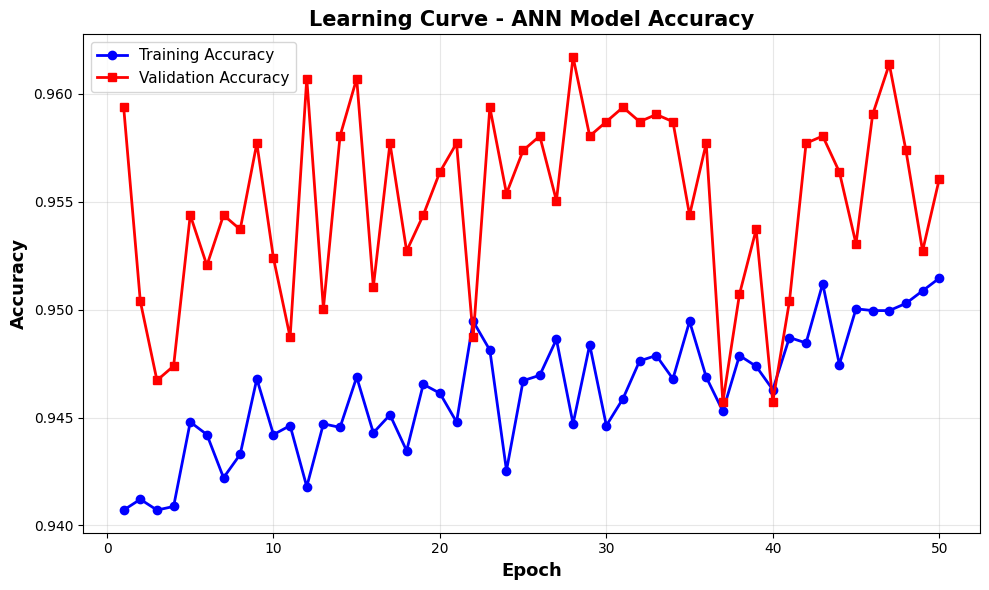

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
epochs = range(1, len(history['accuracy']) + 1)

plt.plot(epochs, history['accuracy'], 'b-o', label='Training Accuracy', linewidth=2, markersize=6)
plt.plot(epochs, history['val_accuracy'], 'r-s', label='Validation Accuracy', linewidth=2, markersize=6)
plt.xlabel('Epoch', fontsize=13, fontweight='bold')
plt.ylabel('Accuracy', fontsize=13, fontweight='bold')
plt.title('Learning Curve - ANN Model Accuracy', fontsize=15, fontweight='bold')
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('plots/ann_learning_curve.png', dpi=300, bbox_inches='tight')
plt.show()


### **Loss Curve**

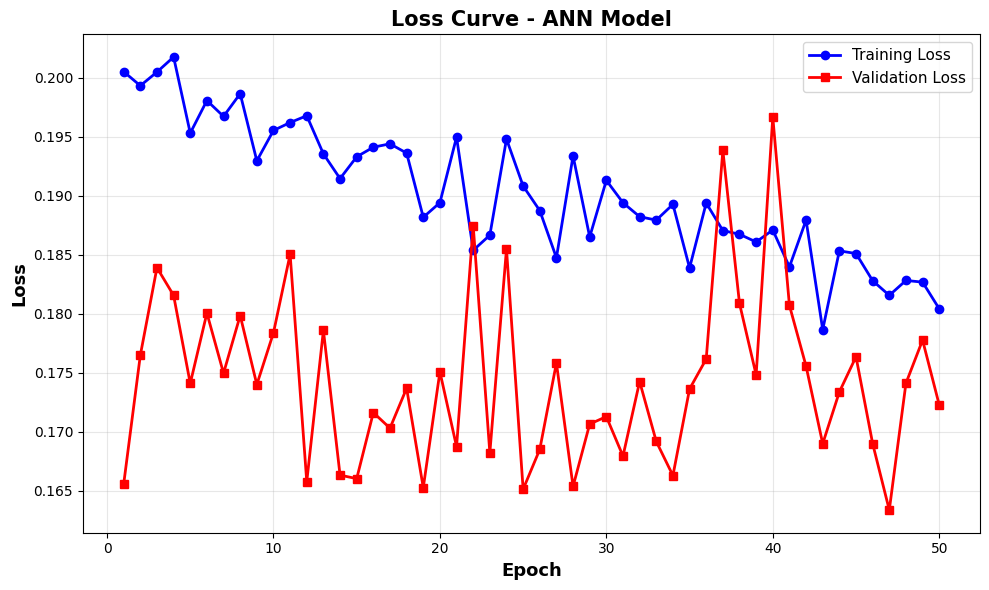

In [ ]:
plt.figure(figsize=(10, 6))
epochs = range(1, len(history['loss']) + 1)

plt.plot(epochs, history['loss'], 'b-o', label='Training Loss', linewidth=2, markersize=6)
plt.plot(epochs, history['val_loss'], 'r-s', label='Validation Loss', linewidth=2, markersize=6)
plt.xlabel('Epoch', fontsize=13, fontweight='bold')
plt.ylabel('Loss', fontsize=13, fontweight='bold')
plt.title('Loss Curve - ANN Model', fontsize=15, fontweight='bold')
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('plots/ann_loss_curve.png', dpi=300, bbox_inches='tight')
plt.show()


### **Combined Training Curves**

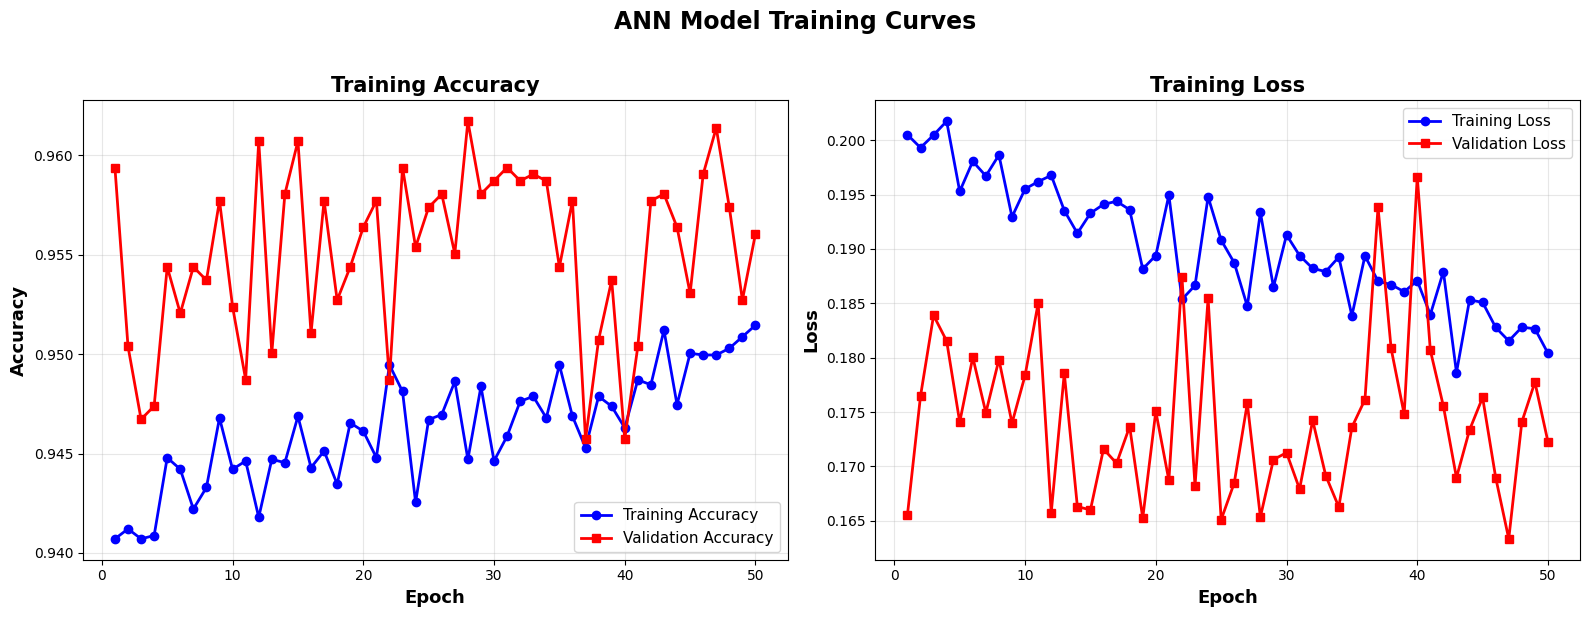

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
epochs = range(1, len(history['accuracy']) + 1)

# Accuracy
ax1.plot(epochs, history['accuracy'], 'b-o', label='Training Accuracy', linewidth=2, markersize=6)
ax1.plot(epochs, history['val_accuracy'], 'r-s', label='Validation Accuracy', linewidth=2, markersize=6)
ax1.set_xlabel('Epoch', fontsize=13, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=13, fontweight='bold')
ax1.set_title('Training Accuracy', fontsize=15, fontweight='bold')
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)

# Loss
ax2.plot(epochs, history['loss'], 'b-o', label='Training Loss', linewidth=2, markersize=6)
ax2.plot(epochs, history['val_loss'], 'r-s', label='Validation Loss', linewidth=2, markersize=6)
ax2.set_xlabel('Epoch', fontsize=13, fontweight='bold')
ax2.set_ylabel('Loss', fontsize=13, fontweight='bold')
ax2.set_title('Training Loss', fontsize=15, fontweight='bold')
ax2.legend(loc='best', fontsize=11)
ax2.grid(True, alpha=0.3)

plt.suptitle('ANN Model Training Curves', fontsize=17, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('plots/ann_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()


### **ROC**

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


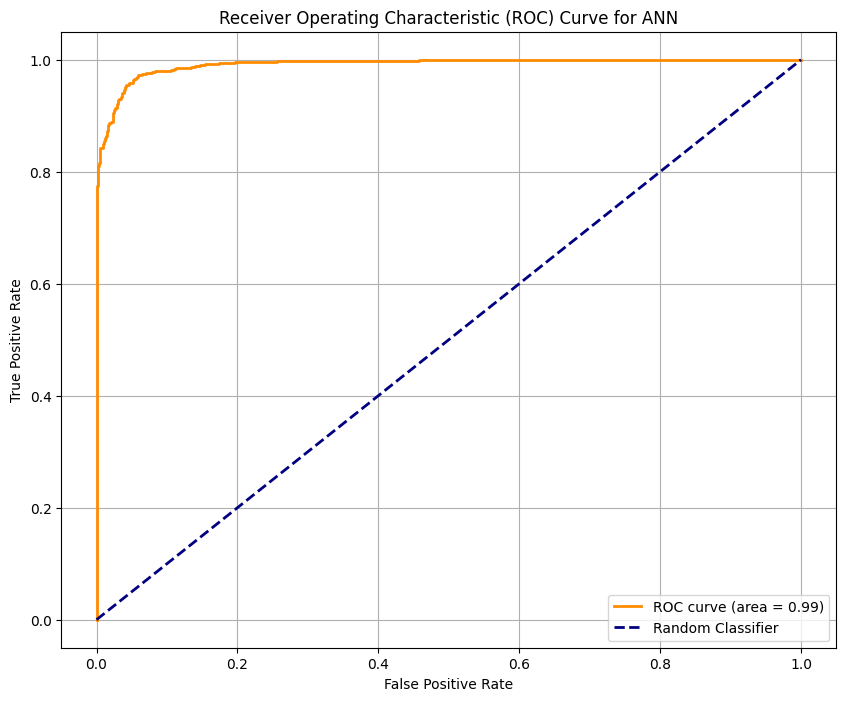

In [ ]:
from sklearn.metrics import roc_curve, auc

y_pred_proba_ann = ann_model.predict(X_test_scaled)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_ann)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for ANN')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("plots/ann_roc_curve.png")
plt.show()

###  **Confusion Matrix**

<Figure size 800x600 with 0 Axes>

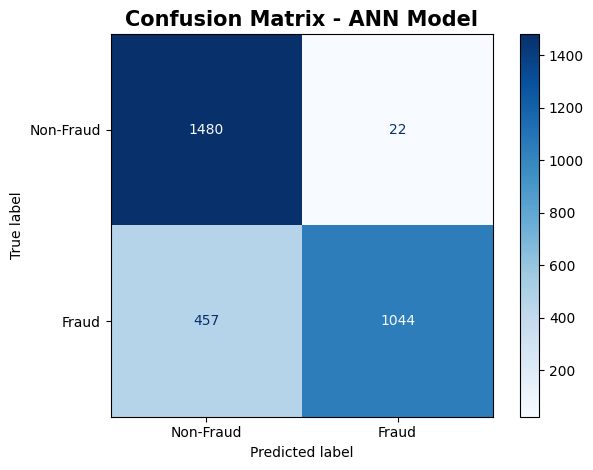

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - ANN Model', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('plots/ann_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

### **Comparative Bar Chart**

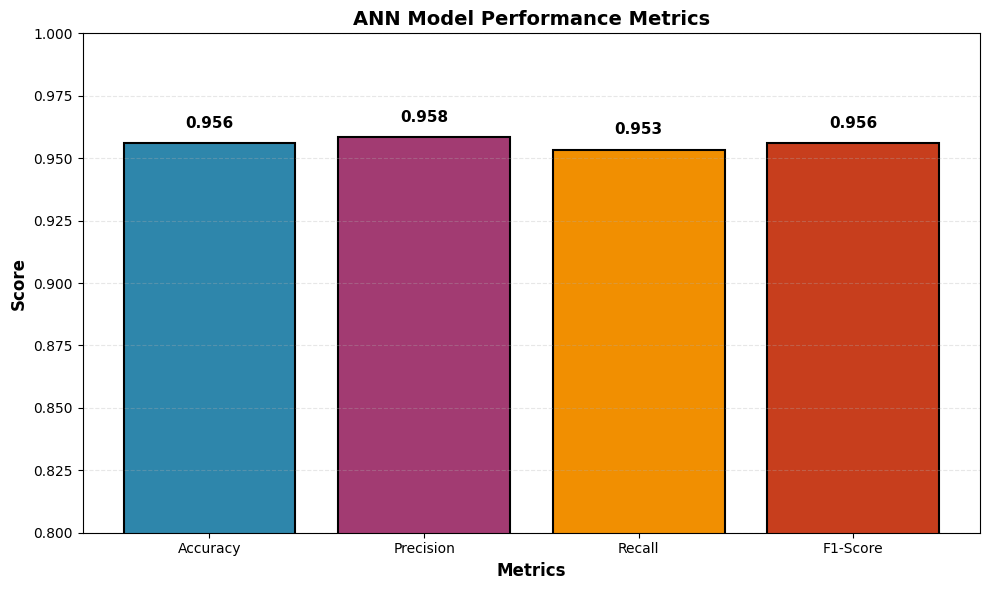

✓ All plots generated successfully!


In [ ]:
scores = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
ann_values = [ann_acc, ann_precision, ann_recall, ann_f1]

plt.figure(figsize=(10, 6))
bars = plt.bar(scores, ann_values, color=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'],
               edgecolor='black', linewidth=1.5)
plt.ylim([0.8, 1.0])
plt.ylabel('Score', fontsize=12, fontweight='bold')
plt.xlabel('Metrics', fontsize=12, fontweight='bold')
plt.title('ANN Model Performance Metrics', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3, linestyle='--')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{height:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('plots/ann_metrics_bar.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ All plots generated successfully!")